# Spectrogram Shifting

In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## fastai imports
import random
from IPython.core.debugger import set_trace
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataAugmentation import *

In [3]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))
untar_data(data_url, dest=data_folder)

PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

64000


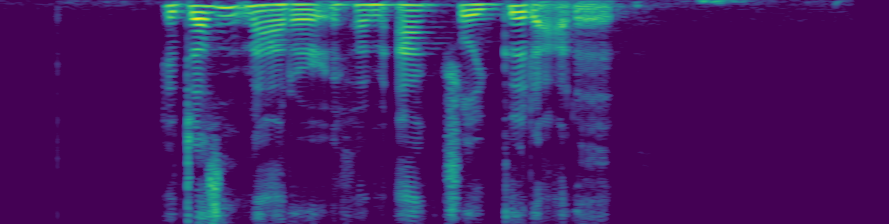

In [4]:
max_length = (4*16000)
print(max_length)
tfm_params = {
    'max_to_pad': max_length,
    'use_spectro': True, 
    'cache_spectro': True, 
    'to_db_scale': True,
    'f_max': 120
}

audios = (AudioList.from_folder(data_folder, **tfm_params)
         )
audios[10].show()

In [5]:
def make_learner(data):
    newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    newlayer = newlayer.cuda()
    learn = cnn_learner(data, models.resnet18, metrics=accuracy)
    learn.model[0][0] = newlayer
    learn.unfreeze()
    return learn

In [6]:
## Regex to get the speaker ID in our file name (our label)
label_pattern = r'_([mf]\d+)_'
bs = 64
label_data = audios.split_by_rand_pct(0.2, seed=2).label_from_re(label_pattern)
label_data.train.x.tfm_args = tfm_params
label_data.valid.x.tfm_args = tfm_params
label_data

LabelLists;

Train: LabelList (3074 items)
x: AudioList
AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).
y: CategoryList
f0003,f0001,f0001,f0001,f0001
Path: /home/h/.fastai/data/ST-AEDS-20180100_1-OS;

Valid: LabelList (768 items)
x: AudioList
AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).,AudioItem: 4.0sec (64000 @ 16000hz).
y: CategoryList
m0002,f0002,f0002,f0003,m0001
Path: /home/h/.fastai/data/ST-AEDS-20180100_1-OS;

Test: None

In [7]:
def tfm_sg_aug(mel, num_vert=0, num_hori=1, pct_vert=0.1, pct_hori=0.2, start_hori=None, start_vert=None, **kwargs):
    occluded = mel.clone().squeeze(0)
    mean = occluded.mean()
    x, y = occluded.shape
    for _ in range(num_vert):
        mask_height = math.floor(y*pct_vert)
        mask = torch.ones(x, mask_height) * mean
        if start_vert is None: start_vert = random.randint(0, y-mask_height)
        if not 0 <= start_vert <= y-mask_height: raise ValueError(f"start_vert value '{start_vert}' out of range")
        occluded[:,start_vert:start_vert+mask_height] = mask
        start_vert = None
    for _ in range(num_hori):
        mask_width = math.floor(x*pct_hori)
        mask = torch.ones(mask_width, y) * mean
        if start_hori is None: start_hori = random.randint(0, x-mask_width)
        if not 0 <= start_hori <= x-mask_width: raise ValueError(f"start_hori value '{start_hori}' out of range")
        occluded[start_hori:start_hori+mask_width,:] = mask
        start_hori = None
    occluded = occluded.unsqueeze(0)
    return occluded

In [13]:
def tfm_sg_shift(spectro, max_shift_pct=0.7, direction=0):
    '''
    direction to move in: 0 is both
    '''
    
    if len(spectro.shape) < 2:
        raise Exception('You are trying to apply the tranform to as signal')
    
    if direction == 0: 
        direction = 1 if random.random() < 0.5 else -1 
    
    s = spectro.clone()
    width = s.shape[1]
    roll_by = int(width*random.random()*max_shift_pct*direction)
    s = s.roll(roll_by, dims=2)
    return s

tfms = [tfm_sg_shift, tfm_sg_aug], []

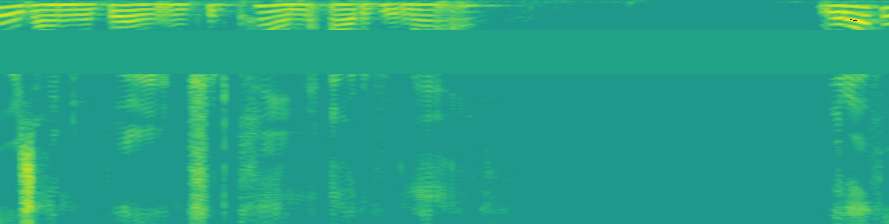

In [14]:
db = label_data.transform(tfms).databunch(bs=bs)
db.train_ds[1][0].show()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


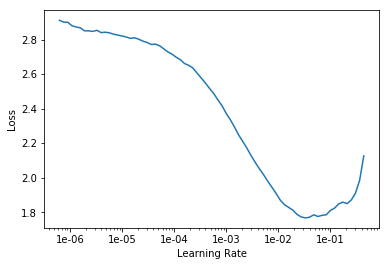

In [15]:
learn = make_learner(db)
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(4, slice(1e-4, 4e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.187849,2.330175,0.291667,00:19
1,0.482742,0.099135,0.968750,00:19
2,0.225240,0.020389,0.994792,00:19
3,0.115538,0.013366,0.997396,00:19


[('f0004', 'f0001', 1),
 ('f0005', 'f0001', 1),
 ('m0001', 'm0002', 1),
 ('m0001', 'm0003', 1)]

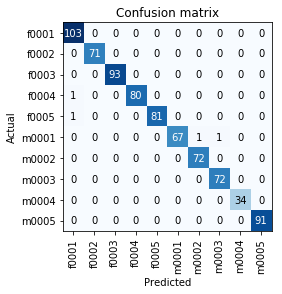

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused()